# Some specific inspections

We inspect the following items:
- The training scenarios
- Inspection of ideal MILP
- Inspection of our hybrid method

In [1]:
using DataFrames, CSV, BSON
using BSON: @save, @load
using Plots, Plots.Measures
using LaTeXStrings
using HEMS
using Printf
using Flux, StatsBase
using Revise, HEMS

ENV["COLUMNS"] = 2000;

In [2]:
root_dir = "../../"
img_dir = joinpath(root_dir, "img")
scenario_dir = joinpath(root_dir, "data/learning/scenarios/")
IL_model_dir = joinpath(root_dir, "model/IL")

"../../model/IL"

In [3]:
# home configuration
home_dir = joinpath(root_dir, "data/home/")
h = read_home_config(joinpath(home_dir, "home.toml"))
;

In [4]:
## Plots default
default(; labelfontsize = 13, tickfontsize = 11,
    framestyle = :box,
    margin = 0.5mm,
    xticks = 0:2:24,
    legendfontsize=11
)

## Plot training scenarios

In [5]:
ss_2019 = BSON.load(joinpath(scenario_dir, "2019.bson"))[:ss] .|> DataFrame
ss_2020 = BSON.load(joinpath(scenario_dir, "2020.bson"))[:ss] .|> DataFrame
ss_2021 = BSON.load(joinpath(scenario_dir, "2021.bson"))[:ss] .|> DataFrame
first(ss_2019)

,ρ,PPV
,Float64,Float64
1,0.0901989,0.0
2,0.0888795,0.0
3,0.0818565,0.0
4,0.101792,0.0
5,0.0849343,0.0
6,0.124614,0.0
7,0.08178,0.0
8,0.0858055,0.0505899
9,0.0896529,0.606784


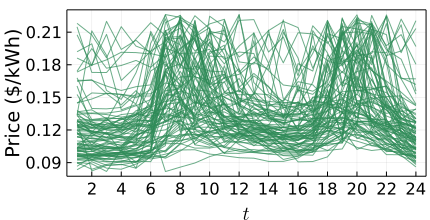

In [6]:
n = 90
p1 = plot(1:24, hcat((ss_2019[i].ρ for i = 1:n)...); size = (430, 220), color = :seagreen, linealpha = 0.7,
    xlabel = L"$t$", ylabel = "Price (\$\$/kWh)",
    right_margin = -1mm, bottom_margin = 1.5mm, legend=false)
savefig(joinpath(img_dir, "price.pdf"))
current()

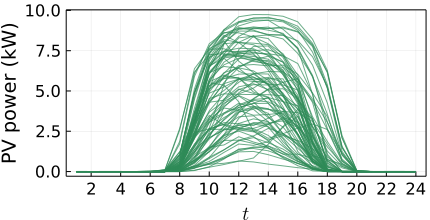

In [7]:
p2 = plot(1:24, hcat((ss_2019[i].PPV for i = 1:n)...); size = (430, 220), color = :seagreen, linealpha = 0.7,
    xlabel = L"$t$", ylabel = "PV power (kW)",
    right_margin = -1mm, bottom_margin = 1.5mm, legend=false)
savefig(joinpath(img_dir, "PV.pdf"))
current()

## One scenario inspection of ideal MILP

In [8]:
s = ss_2020[213] |> copy;    # 213 -> Aug. 1st

In [9]:
model = run_MILP!(s, h)
s;

In [31]:
left_margin = 1mm
fs = (430, 200)
fst = (430, 220)
xticks = 0:2:24
markershape = :circle

:circle

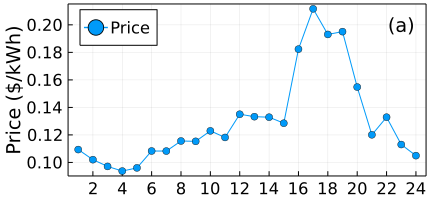

In [32]:
plot(1:24, s.ρ; size = fs, ylabel = "Price (\$\$/kWh)", xticks, markershape,
    left_margin, right_margin = -1mm, top_margin = -1mm, label = "Price", legend = :topleft,
    yticks=0.1:0.02:0.2)
annotate!(23, 0.2, Plots.text("(a)", 13))
savefig(joinpath(img_dir, "price_MILP_small.pdf"))
current()

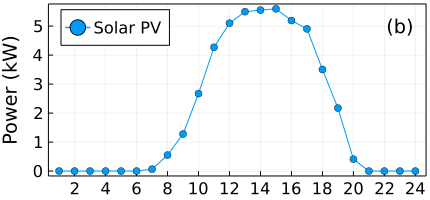

In [34]:
plot(1:24, s.PPV; size = fs, ylabel = "Power (kW)", xticks, markershape, left_margin,
     right_margin = -1mm, top_margin = -1mm, label = "Solar PV", legend = :topleft,
     yticks = (0:5, [@sprintf("%2d", y) for y in 0:5]))
annotate!(23, 5, text("(b)", 13))
savefig(joinpath(img_dir, "PV_MILP_small.pdf"))
current()

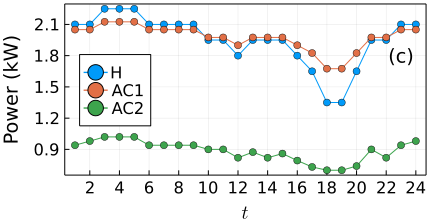

In [35]:
# adjustable
ads = [l["id"] for l in h["AD"]]
plot(; size = fst, left_margin, right_margin = -1mm, ylabel = "Power (kW)", top_margin = -1mm,
    bottom_margin = 1.8mm, yticks = (0.9:0.3:2.1, [@sprintf("%4.1f", y) for y in 0.9:0.3:2.1]),
    legend = (0.13, 0.6), xlabel = L"t")
for id in ads
    plot!(1:24, s[!, "P_$id"]; markershape = :circle, label = id)
end
annotate!(23, 1.8, text("(c)", 13))
savefig(joinpath(img_dir, "AD_MILP_small.pdf"))
current()

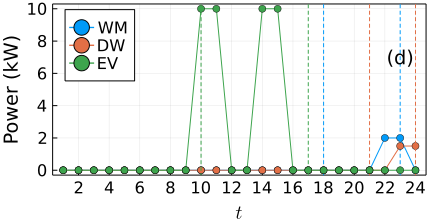

In [36]:
# shiftable
shifts = Iterators.Flatten((h["SU"], h["SI"]))
plot(; size = fst, left_margin, right_margin = -1mm, ylabel = "Power (kW)", 
    legend = :topleft, yticks=0:2:10, xlabel=L"t", bottom_margin = 1.8mm, top_margin=-1mm)
for (i, l) in enumerate(shifts)
    id = l["id"]
    plot!(1:24, s[!, "P_$id"]; markershape = :circle, label = id,
        color = i)
    vline!([l["ts"], l["tf"]]; color = i, linestyle = :dash, label = false)
end
annotate!(23, 7, text("(d)", 13))
savefig(joinpath(img_dir, "S_MILP_small.pdf"))
current()

In [17]:
sum(s.C), sum(s.Cele), compute_cost!(copy(s), h)

(5.8436849075, 19.087421004203733, 15.647269137912083, 19.087323319539593)

## Inspection of hybrid method

In [18]:
# a scenario in the test set
s = ss_2021[161];    # June 10

### Get results with two methods

In [19]:
# ideal MILP 
sm = copy(s) 
run_MILP!(sm, h);

In [20]:
# hybrid
@load joinpath(IL_model_dir, "agents.bson") agents
sh = manage_loads(s, h, agents);

t = 10
only(agent(state)) = 0.4269430007855779
t = 11
only(agent(state)) = 0.15514019738652193
t = 12
only(agent(state)) = 0.3537479339262902
t = 13
only(agent(state)) = 0.3748586218345501
P_shiftable = [0.0, 0.0, 10.0]
P_other = 10.7
value(sum((model[Symbol("P_", l["id"])] for l = ls))) = 4.825
value(model[:Pb]) = 9.165353504876101
value(model[:Ps]) = 0.0
PPV = 6.359646495123897


### Plot and analyze

In [21]:
fs = (430, 200)
fst = (430, 220)
xticks = 0:2:24
markershape = :circle

:circle

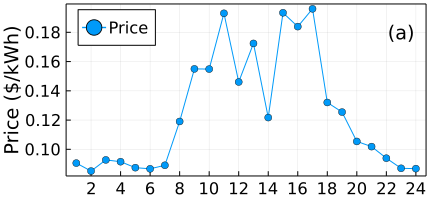

In [22]:
# price and PV 
plot(1:24, s.ρ; size = fs, ylabel = "Price (\$\$/kWh)", xticks, markershape,
    right_margin = -1mm, top_margin = -1mm, label = "Price", legend = :topleft)
annotate!(23, 0.18, Plots.text("(a)", 13))
savefig(joinpath(img_dir, "price_h.pdf"))
current()

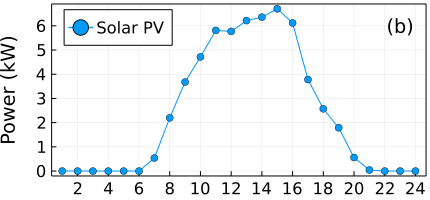

In [23]:
# price and PV 
plot(1:24, s.PPV; size = fs, ylabel = "Power (kW)", xticks, markershape,
    right_margin = -1mm, top_margin = -1mm, label = "Solar PV", legend = :topleft,
    yticks = (0:6, [@sprintf("%3d", y) for y in 0:6]))
annotate!(23, 6, text("(b)", 13))
savefig(joinpath(img_dir, "PV_h.pdf"))
current()

In [24]:
# shiftable loads 
function plot_shiftable(s, file_name; yticks=:auto, ann="")
    shifts = Iterators.Flatten((h["SU"], h["SI"]))
    plot(; size = fs, ylabel = "Power (kW)",
        legend = :topleft, 
        yticks, 
        xticks,
        right_margin = -1mm, top_margin = -1mm)
    for (i, l) in enumerate(shifts)
        id = l["id"]
        plot!(1:24, s[!, "P_$id"]; markershape = :circle, label = id,
            color = i)
        vline!([l["ts"], l["tf"]]; color = i, linestyle = :dash, label = false)
    end
    annotate!(23, 9, text(ann, 13))
    savefig(joinpath(img_dir, file_name))
    current()
end

plot_shiftable (generic function with 1 method)

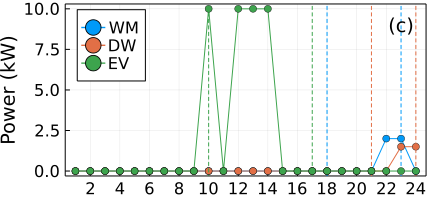

In [25]:
plot_shiftable(sm, "S_h_MILP.pdf"; ann="(c)")

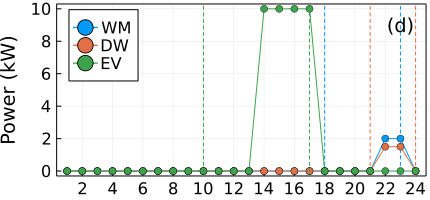

In [26]:
plot_shiftable(sh, "S_h.pdf"; yticks=(0:2:10, [@sprintf("%3.f", y) for y in 0:2:10]), ann="(d)")

In [27]:
# adjustable
function plot_adjustable(s, file_name; yticks = :auto, ann = "")
    ads = [l["id"] for l in h["AD"]]
    plot(; size = fs, ylabel = "Power (kW)",
        legend = (0.12, 0.6), right_margin = -1mm, top_margin = -1mm, xticks, yticks)
    for id in ads
        plot!(1:24, s[!, "P_$id"]; markershape = :circle, label = id)
    end
    annotate!(23, 1.9, text(ann, 13))
    savefig(joinpath(img_dir, file_name))
    current()
end

plot_adjustable (generic function with 1 method)

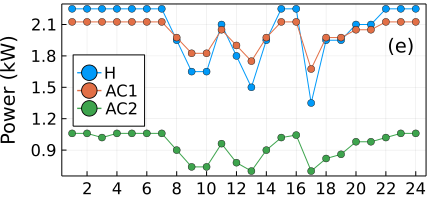

In [28]:
plot_adjustable(sm, "A_h_MILP.pdf"; yticks = (0.9:0.3:2.1, [@sprintf("%4.1f", y) for y in 0.9:0.3:2.1]), ann="(e)")

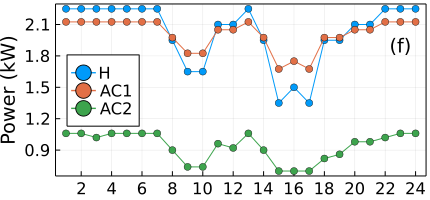

In [29]:
plot_adjustable(sh, "A_h.pdf"; ann="(f)")

In [30]:
function plot_exchange(s, file_name; yticks = :auto, ann = "")
    ads = [l["id"] for l in h["AD"]]
    plot(; size = fst, ylabel = "Power (kW)",
        legend = :topleft, right_margin = -1mm, top_margin = -1.5mm, xticks, yticks, xlabel = L"t",
        bottom_margin = 1.5mm, ylimits=[-1, 11])
    plot!(1:24, s.Pb .- s.Ps; label = L"P^{\textrm{net}}", markershape = :circle)
    annotate!(23, 6, text(ann, 13))
    savefig(joinpath(img_dir, file_name))
    current()
end

plot_exchange (generic function with 1 method)

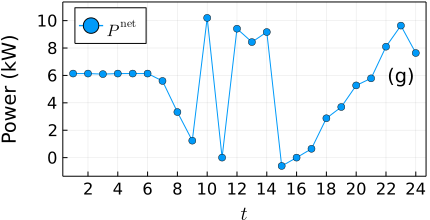

In [31]:
plot_exchange(sm, "ex_h_MILP.pdf"; ann = "(g)", yticks = (0:2:10, [@sprintf("%4d", y) for y in 0:2:10]))

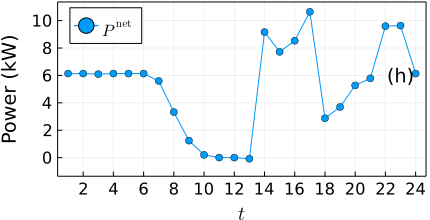

In [32]:
plot_exchange(sh, "ex_h.pdf"; ann="(h)", yticks=(0:2:10, [@sprintf("%3d", y) for y in 0:2:10]))

In [39]:
function assign_adjustable_power!(df_dst, df_src, h)
    for l in h["AD"]
        id = l["id"]
        df_dst[:, "P_$id"] .= df_src[!, "P_$id"]
    end
    # update Pb and Ps based on power balance
    Pcr = sum(l["P"] for l in h["CR"])
    Pnet = fill(Pcr, nrow(df_dst))
    for l in Iterators.Flatten((h["AD"], h["SU"], h["SI"]))
        Pnet .+= df_dst[!, "P_$(l["id"])"]
    end
    Pnet .-= df_dst.PPV
    df_dst.Pb = max.(Pnet, 0)
    df_dst.Ps = -min.(Pnet, 0)
end

assign_adjustable_power! (generic function with 1 method)

In [40]:
# in `so`, shiftable loads are controlled by DNN, adjustable loads with the ideal MILP's values.
so = copy(sh)
assign_adjustable_power!(so, sm, h);

In [41]:
compute_cost!(so, h), compute_cost!(sh, h), compute_cost!(sm, h)

(18.239672283219864, 17.976727422310223, 17.109384322182105)